In [1]:
import pandas as pd
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import itertools
import os, sys, datetime

In [2]:
# 讀取來源檔案 遮蔽時會讀取以儲存npy檔案
new_data=False
filter_ths = 100
if new_data==True:
    raw_data = pd.read_csv('./4602_SARS-CoV-2_pima_0708.csv')
else:
    # npy path
    train_npy = [f'./dataset2/numpy_train_test_split_added time/X_train_{filter_ths}up_weeks.npy', f'./dataset2/numpy_train_test_split_added time/y_train_{filter_ths}up_weeks.npy']
    test_npy = [f'./dataset2/numpy_train_test_split_added time/X_test_{filter_ths}up_weeks.npy', f'./dataset2/numpy_train_test_split_added time/y_test_{filter_ths}up_weeks.npy']


In [3]:
class data_loader:
    def __init__(self, x_train, y_train, x_test, y_test):

        self.x_train = np.array(x_train)
        self.x_test = np.array(x_test)
        self.y_train = np.array(y_train)
        self.y_test = np.array(y_test)
        print(self.x_train.shape, self.y_train.shape, self.x_test.shape, self.y_test.shape)

    def get_index(self, data_list, GT_list, b):
        labels = []
        datas =[]
        for patch, i in enumerate(GT_list):
            for index, label in enumerate(b):
                if i==label:
                    labels.append(index)
                    datas.append(data_list[patch])
        return datas, labels

    def npy_loading(self):
        # train processing
        b1, _, _, w1= np.unique(self.y_train,return_counts=True,return_index=True,return_inverse=True)
        # test(valid) processing
        b2, _, _, w2= np.unique(self.y_test,return_counts=True,return_index=True,return_inverse=True)
        X_train, Y_train = self.get_index(self.x_train, self.y_train, b2)
        X_test, Y_test = self.get_index(self.x_test, self.y_test, b2)

        return np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test), b2

batch_size = 32
# dataset npy loading
loader = data_loader(np.load(train_npy[0], allow_pickle=True), np.load(train_npy[1], allow_pickle=True), 
                    np.load(test_npy[0], allow_pickle=True), np.load(test_npy[1], allow_pickle=True))

X_train, y_train,X_test, y_test, test_class = loader.npy_loading()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

class_n = len(test_class)
print('train class', max(y_train)+1, 'test class', max(y_test)+1)


# pytorch data zip processing
train_zip = TensorDataset(torch.tensor(X_train), torch.tensor(y_train)) #zip X, y
test_zip = TensorDataset(torch.tensor(X_test), torch.tensor(y_test)) #zip X, y
train_loader = DataLoader(dataset=train_zip, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=test_zip, batch_size=batch_size, shuffle=False)

(1696, 56575) (1696,) (566, 56575) (566,)
(1696, 56575) (1696,) (566, 56575) (566,)
train class 7 test class 7


In [4]:
Input_Size = X_train.shape[1]
class RNN(nn.Module):
    def __init__(self, class_n):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=Input_Size,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
        )

        self.out = nn.Linear(128, class_n)
    def forward(self, x):
        r_out, (h_c, h_h) = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight.data, 0, 0.01)
                # m.weight.data.normal_(0,0.01)
                m.bias.data.zero_()

In [5]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [6]:
# from tqdm import tqdm_notebook
# LR = 0.0001
# stop_count = 0
# rnn = RNN(max(y_train)+1).cuda()
# optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
# loss_fun = nn.CrossEntropyLoss()
# tloss_stack, vloss_stack, t_acc_stack, v_acc_stack = [], [], [], []
# min_valid_loss = np.inf
# for epoch in tqdm_notebook(range(1000)):
# # for epoch in range(EPOCH):
#     for step, (b_x, b_y) in enumerate(train_loader):
#         # Forward pass
#         rnn.train()
#         train_loss = 0.0
#         if torch.cuda.is_available():
#             b_x, b_y= (torch.unsqueeze(b_x, 1)).data.type(torch.FloatTensor).cuda(), b_y.cuda()
        
#         optimizer.zero_grad()
#         r_out = rnn(b_x)
#         loss = loss_fun(r_out, b_y)
#         loss.backward()
#         optimizer.step()
#         train_loss = loss.item()*b_x.size(0)
#     tloss_stack.append(loss)

    
#     # Validation
#     valid_loss = 0.0
#     rnn.eval()
#     for step, (b_x, b_y) in enumerate(valid_loader):
#         if torch.cuda.is_available():
#             b_x, b_y= (torch.unsqueeze(b_x, 1)).data.type(torch.FloatTensor).cuda(), b_y.cuda()
#         r_out = rnn(b_x)
#         loss = loss_fun(r_out, b_y)
#         valid_loss = loss.item()*b_x.size(0)
#     vloss_stack.append(loss) 

#     if min_valid_loss > valid_loss:
#         # print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
#         min_valid_loss = valid_loss
          
#         # Saving State Dict
#         torch.save({'state_dict': rnn.state_dict()}, f'./pth/LSTM_week_saved_model_{filter_ths}.pth.tar')

In [7]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,10))
# plt.plot(tloss_stack, label='train loss')
# plt.plot(vloss_stack, label='valid loss')
# plt.xlabel('Epochs', fontsize=18)
# plt.ylabel('CE loss',fontsize=18)
# plt.title(f'LSTM week model Loss plot [nums > {filter_ths}]', fontsize=25)
# plt.legend()
# plt.savefig(f'./results/{filter_ths}_loss_LSTM_week_no-weight-init.jpg')

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
model = RNN(max(y_train)+1).cuda()
checkpoint = torch.load(f'./pth/LSTM_week_saved_model_{filter_ths}.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

RNN(
  (rnn): LSTM(56575, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=7, bias=True)
)

In [9]:
y_pred = []
y_true = [] 
for step, (b_x, b_y) in enumerate(train_loader):
    if torch.cuda.is_available():
        b_x, b_y= (torch.unsqueeze(b_x, 1)).data.type(torch.FloatTensor).cuda(), b_y.cuda()
    r_out = model(b_x)
    _, preds = torch.max(r_out, 1) 
    y_pred.extend(preds.view(-1).detach().cpu().numpy())    
    y_true.extend(b_y.cpu().view(-1).detach().cpu().numpy())  
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

1.0


In [10]:
y_pred = []
y_true = [] 
for step, (b_x, b_y) in enumerate(valid_loader):
    if torch.cuda.is_available():
        b_x, b_y= (torch.unsqueeze(b_x, 1)).data.type(torch.FloatTensor).cuda(), b_y.cuda()
    r_out = model(b_x)
    _, preds = torch.max(r_out, 1) 
    y_pred.extend(preds.view(-1).detach().cpu().numpy())    
    y_true.extend(b_y.cpu().view(-1).detach().cpu().numpy()) 
print(accuracy_score(y_true, y_pred))

0.9893992932862191


[0.97142857 1.         1.         0.99666667 0.98245614 1.
 0.94285714]


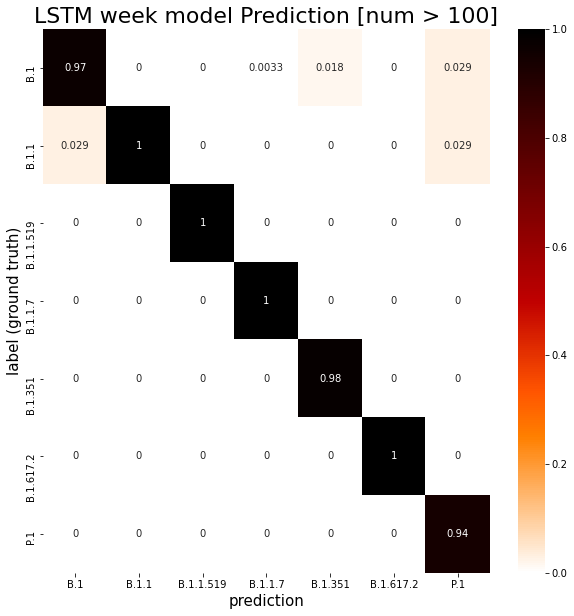

In [11]:
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(y_true, y_pred, normalize='pred') 
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)
print(per_cls_acc)

df_cm = pd.DataFrame(cf_matrix, test_class, test_class)
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, cmap='gist_heat_r')
plt.xlabel("prediction", fontsize =15)
plt.ylabel("label (ground truth)", fontsize =15)
plt.title(f'LSTM week model Prediction [num > {filter_ths}]', fontsize=22)
plt.savefig(f'./results/{filter_ths}_CM_LSTM_week.jpg')